# Momentum Portfolio Analysis

This notebook explores momentum strategies using the ticker returns data stored in the DuckDB database. We will calculate differnt momentum portfolios, and metrics on these portfolios.

This is a draft of what could be implemented:

# Momentum Portfolios
* different rebalancing frequencies (i.e. monthly, quarterly, annually)
* differnt groupings of assets (i.e top/bottom 10%, top/bottom 20%, top/bottom 30%, top/bottom 40%, top/bottom 50%, top/bottom 60%, top/bottom 70%, top/bottom 80%, top/bottom 90%, top/bottom 100%)

# Metrics
* Future Average Returns
* volatility
* Sharpe Ratios
* Market cap distribution
* Correlations/Regressions Analysis:

  Benchmarks Correlations
  Macro Correlations
  Correlations with sentiment indicators

* Portfolio Turnover
* Distribution of Financial Ratios: 

     Book to price ratio, 
     debt to equity ratio, 
     PE
     PEG
     etc

* Option Data: Implied Volatility, skew, put to call ratio.
* Since there tends to be a correlation betwen higher volatiliy and performance of both the long and short sides of the strategy. Adjust the  exposure of the portfolio based on the implied volatility of the stocks held in the portfolio

## 1. Load Data

* Load the returns data from the duckdb created by the yfinance data fetcher for all Equities listed in US Markets

In [1]:
from database_utils import get_available_tickers, load_ticker_data
import duckdb

In [2]:
tickers = get_available_tickers()
print("Tickers", tickers[:30])
print("Length", len(tickers))

Tickers ['A', 'AA', 'AACB', 'AACBU', 'AACG', 'AAL', 'AAME', 'AAMI', 'AAOI', 'AAON', 'AAP', 'AAPG', 'AAPL', 'AARD', 'AAT', 'AAUC', 'AB', 'ABAT', 'ABBV', 'ABCB', 'ABCL', 'ABEO', 'ABEV', 'ABG', 'ABLV', 'ABM', 'ABNB', 'ABOS', 'ABP', 'ABR']
Length 6330


We have daily returns data for  6330 listed tickers in USA markets through yahoo finance

In [3]:
con = duckdb.connect('../database/market_data.db')
print("Tables in the DB", con.execute("SHOW TABLES").df())
print("-"*60)
print("Number of successful tickers:", con.execute("SELECT COUNT(*) FROM successful_tickers").df())
print("-"*60)
print("Number of failed tickers:", con.execute("SELECT COUNT(*) FROM failed_tickers").df())
print("-"*60)
print("Number of rows in full_history:", con.execute("SELECT COUNT(*) FROM full_history").df())
print("-"*60)
print("see row names")
print(con.execute("SELECT * FROM successful_tickers LIMIT 1").df())
print("-"*60)
print(con.execute("SELECT * FROM failed_tickers LIMIT 1").df())
print("-"*60)
print(con.execute("SELECT * FROM full_history LIMIT 2").df())

Tables in the DB                  name
0      failed_tickers
1        full_history
2  successful_tickers
------------------------------------------------------------
Number of successful tickers:    count_star()
0          6330
------------------------------------------------------------
Number of failed tickers:    count_star()
0           364
------------------------------------------------------------
Number of rows in full_history:    count_star()
0      26013190
------------------------------------------------------------
see row names
  ticker
0      A
------------------------------------------------------------
  ticker         error
0  AACBR  Empty result
------------------------------------------------------------
                 date       open       high        low      close    volume  \
0 1999-11-18 14:30:00  32.546494  35.765381  28.612303  31.473534  62546380   
1 1999-11-19 14:30:00  30.713518  30.758226  28.478184  28.880545  15234146   

   adj_close  daily_return  l

In [4]:
# Select the tickers we want to include in the universe
def query(query: str): 
    #helper to query duckdb
    return con.execute(query).df()

def select_tickers_listed_from_start_date(start_date='2010-02-01', min_close_price: int= 5):
    """
    python
    Selects tickers from the history that were listed after a specific date 
    and maintain a minimum initial close price.

    Args:
        start_date (str): The earliest listing date to filter by (YYYY-MM-DD).
        min_close_price (int): The minimum close price required at the listing date.
    """
    q = f"""
        SELECT f.ticker 
        FROM full_history as f
            JOIN successful_tickers as s
            ON f.ticker = s.ticker
        GROUP BY f.ticker 
        HAVING MIN(f.date) < '{start_date}' 
        AND AVG(f.close) > {min_close_price}
    """

    return query(q)


    print(len(tickers))
    print(tickers[:10])

select_tickers_listed_from_start_date('2010-02-01', 5)

,ticker
0,BKE
1,CXH
2,CXT
3,CXW
4,GAM
...,...
2439,LCII
2440,NEON
2441,RRX
2442,SRL


We have the daily data for 3022 tickers for stocks that have been trading for over 10 years in US markets

## 2 Functions to construct portfolio

In [5]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from typing import List, Union, Tuple, Optional


class MomentumPortfolio:
    """
    Constructs and backtests a momentum-based portfolio using historical return data.
    """
    
    def __init__(self):
        self.data: pd.DataFrame = None # this holds the returns of stocks
        self.weights: pd.DataFrame = None # this holds the weights of the portfolio during each period. computing the wighets dictates the behavior of the portfolioC
        self.performance: pd.DataFrame = None # This is the result of simulating the resturns of the portfolio over time by using the pre computed weights and returns of each stock during the HPR
        self.tickers: List[str] = [] # These are the tickers that qualify for the strategy and we use
        self.percentile_results: dict = {}
        self.periods_per_year = None

    def fetch_data(self, tickers: Union[List[str], pd.DataFrame, pd.Series], time_start: str, aggregate: Optional[str] = None, clip_extreme_values: bool = False) -> None:
        """
        This Loads the data for the tickets you pass from the local duck db, for the time period you pass
        the script runs too slow try reducing the time period to use less memory
        """
        if isinstance(tickers, pd.DataFrame):
            self.tickers = tickers.iloc[:, 0].dropna().unique().tolist()
        elif isinstance(tickers, pd.Series):
            self.tickers = tickers.dropna().unique().tolist()
        else:
            self.tickers = list(set(tickers))

        if not self.tickers:
            print("Warning: No valid tickers provided. Data fetch aborted.")
            return

        if len(self.tickers) == 1:
            tickers_str = f"('{self.tickers[0]}')"
        else:
            tickers_str = str(tuple(self.tickers))

        q = f"""
        SELECT date, log_return, ticker, adj_close
        FROM full_history 
        WHERE ticker in {tickers_str} 
        AND date > '{time_start}'
        """
        
        raw_data = query(q)
        
        # convert the returns data to wide column format, keeping just dates and log returns for all tickers
        self.data = raw_data.pivot(index='date', columns='ticker', values='log_return')
        self.data.index = pd.to_datetime(self.data.index)
        


        if aggregate:
            self.data = self.data.resample(aggregate).sum()
            if aggregate == "ME":
                self.periods_per_year = 12
            else:
                raise ValueError("Aggreation period of: {aggregate} is not supported. though it can be added if it is compatible with pandas, ask Julen Marmol, this value is used to compute portfolio nstatistics later on")
        if clip_extreme_values:
            self.data = self.data.replace([np.inf, -np.inf], np.nan)
            self.data = self.data.clip(lower=-0.8, upper=0.8)  

    def compute_weight_momentum_12_minus_1(self, top_percentile: float, bottom_percentile: float = 0, 
                                           long_window: int = 12, short_window: int = 1) -> None:
        """
        THis is the engine of the portfolio, it computes the weights of the portfolio based on the momentum of the stocks 
        and simulates the weights you have to alocate to alocate stocks of a selected percentile range based on the 
        momentum methodology into the portdolio.
        You can adjust how many periods to ignore, and how long the lookback period is.
        """
        if self.data is None:
            raise ValueError("Data not fetched. Call fetch_data() first.")
        r = self.data.shift(1) 
        long_return = r.rolling(window=long_window).sum()
        short_return = r.rolling(window=short_window).sum()
        momentum_signal = long_return - short_return

        rows = []

        start_p = min(top_percentile, bottom_percentile)
        end_p = max(top_percentile, bottom_percentile)

        for date, row_signal in momentum_signal.iterrows():
            if row_signal.isnull().all():
                continue
                
            sorted_row = row_signal.sort_values(ascending=True)
            valid_assets = sorted_row.dropna()
            l = len(valid_assets)
            
            if l == 0: 
                continue
            
            start_idx = int(start_p * l / 100)
            end_idx = int(end_p * l / 100)
            
            if start_idx == end_idx and end_idx < l:
                end_idx += 1
                
            selected_tickers = valid_assets.index[start_idx:end_idx].tolist()

            if not selected_tickers:
                rows.append({**{t: 0.0 for t in sorted_row.index}, "date": date})
                continue
                
            weight_val = 1.0 / len(selected_tickers)
            ticker_to_weight = {ticker: 0.0 for ticker in sorted_row.index}
            
            for t in selected_tickers:
                ticker_to_weight[t] = weight_val
            
            ticker_to_weight["date"] = date
            rows.append(ticker_to_weight)
            
        self.weights = pd.DataFrame(rows)
        if not self.weights.empty:
            self.weights.set_index("date", inplace=True)

    def compute_index_level_and_returns(self, start_index: float = 100.0) -> pd.DataFrame:
        """
        This function computes the performance of the portfolio by using the weights and returns of each stock during the HPR.
        in the memory of this class, only the last weights computed are stored. calculate wights for each percentile range individually.
        """

        if self.weights is None or self.weights.empty:
            return pd.DataFrame() 

        # Shift weights forward by 1 period to execute the trade AFTER the signal is generated
        effective_weights = self.weights.shift(1)
        
        # --- THE FIX: Convert individual log returns to simple returns ---
        simple_returns = np.exp(self.data) - 1
        
        # Calculate cross-sectional portfolio simple returns
        weighted_simple_returns = effective_weights * simple_returns
        
        self.performance = pd.DataFrame(index=self.data.index)
        self.performance['portfolio_simple_return'] = weighted_simple_returns.sum(axis=1)
        
        # Drop the initial periods where we had signals but no forward returns yet
        self.performance.dropna(subset=['portfolio_simple_return'], inplace=True)
        # Drop rows where portfolio return is exactly 0.0 before the strategy is fully invested
        #self.performance = self.performance.loc[(self.performance != 0).any(axis=1)]
        
        # --- THE FIX: Convert portfolio simple return back to log return for cumulation ---
        self.performance['portfolio_log_return'] = np.log(1 + self.performance['portfolio_simple_return'])
        
        # Calculate Index Level mathematically
        self.performance['cumulative_log_return'] = self.performance['portfolio_log_return'].cumsum()
        self.performance['index_level'] = start_index * np.exp(self.performance['cumulative_log_return'])
        
        return self.performance

    def construct_performances_for_percentiles(self, percentiles: List[Union[List[float], Tuple[float, float]]], long_window, short_window) -> None:
        """
        This creates the performance for a list of percentile ranges in tuple format,
        load returns data first.

        percentiles = [(0,10),(10,20),(20,30),...]
        """
        if self.data is None:
            raise ValueError("Data not loaded. Please call fetch_data() first.")

        self.percentile_results = {}
        
        for top_p, bottom_p in percentiles:
            self.compute_weight_momentum_12_minus_1(top_percentile=top_p, bottom_percentile=bottom_p, long_window=long_window, short_window=short_window)
            perf_df = self.compute_index_level_and_returns()
            
            start_p = min(top_p, bottom_p)
            end_p = max(top_p, bottom_p)
            key_name = f"Percentile {start_p}% to {end_p}%"
            
            self.percentile_results[key_name] = perf_df.copy()

    def construct_portfolio_average_holding_period_returns(self) -> pd.Series:
        if not self.percentile_results:
            print("No performances stored. Run construct_performances_for_percentiles() first.")
            return pd.Series(dtype=float)

        stats = {name: df['portfolio_log_return'].mean() 
                 for name, df in self.percentile_results.items() if not df.empty}
            
        return pd.Series(stats, name="Average HPR (Log)")
    
    def construct_portfolio_average_standard_deviation_for_holding_period_return(self) -> pd.Series:
        if not self.percentile_results:
            print("No performances stored. Run construct_performances_for_percentiles() first.")
            return pd.Series(dtype=float)

        stats = {name: df['portfolio_log_return'].std() 
                 for name, df in self.percentile_results.items() if not df.empty}
            
        return pd.Series(stats, name="Std Dev HPR (Log)")

    def plot_portfolios_over_HPR(self) -> None:
        if not self.percentile_results:
            print("No performances to plot.")
            return

        plt.figure(figsize=(12, 6))
        
        for name, df in self.percentile_results.items():
            if not df.empty:
                plt.plot(df.index, df['index_level'], label=name)
            
        plt.title("Momentum Portfolio Performance Comparison")
        plt.xlabel("Date")
        plt.ylabel("Index Level")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def plot_portfolio_average_returns(self, return_type: str = "simple") -> None:
        avg_log_returns = self.construct_portfolio_average_holding_period_returns()
        
        if avg_log_returns.empty:
            print("No data to plot.")
            return

        if return_type == "simple":
            avg_returns = np.exp(avg_log_returns) - 1
            ylabel = "Average Simple Return (%)"
        elif return_type == "log":
            avg_returns = avg_log_returns
            ylabel = "Average Log Return (%)"
        else:
            raise ValueError("return_type must be 'simple' or 'log'")

        plt.figure(figsize=(10, 6))
        avg_returns.plot(kind='bar', alpha=0.8)

        plt.title("Average Holding Period Return by Strategy Slice")
        plt.xlabel("Strategy Selection")
        plt.ylabel(ylabel)
        plt.xticks(rotation=45, ha='right')

        plt.gca().yaxis.set_major_formatter(
            plt.FuncFormatter(lambda y, _: f"{y*100:.2f}%")
        )

        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()


    def plot_portfolio_standard_deviations(self) -> None:
        std_devs = self.construct_portfolio_average_standard_deviation_for_holding_period_return()
        
        if std_devs.empty:
            print("No data to plot.")
            return

        plt.figure(figsize=(10, 6))
        std_devs.plot(kind='bar', color='salmon', alpha=0.8)
        
        plt.title("Volatility (Std Dev) by Strategy Slice")
        plt.xlabel("Strategy Selection")
        plt.ylabel("Standard Deviation of Returns")
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    def print_portfolio_statistics(self, risk_free_rate: float = 0.0) -> None:
        """
        Calculates and prints absolute performance metrics (Sharpe, Max Drawdown) 
        and plots the 12-month rolling volatility for all stored strategies.
        """
        if not self.percentile_results:
            print("No performances stored. Run construct_performances_for_percentiles() first.")
            return

        stats_list = []
        
        plt.figure(figsize=(12, 6))
        
        for name, df in self.percentile_results.items():
            if df.empty:
                continue
                
            returns = df['portfolio_simple_return']
            
            # --- THE FIX: ADD 'self.' TO PERIODS_PER_YEAR ---
            # Annualized Return & Volatility
            ann_return = (1 + returns.mean()) ** self.periods_per_year - 1
            ann_vol = returns.std() * np.sqrt(self.periods_per_year)
            
            # Sharpe Ratio
            sharpe = (ann_return - risk_free_rate) / ann_vol if ann_vol != 0 else 0
            
            # Max Drawdown
            cum_ret = (1 + returns).cumprod()
            rolling_max = cum_ret.cummax()
            drawdown = cum_ret / rolling_max - 1
            max_drawdown = drawdown.min()
            
            # Add to table
            stats_list.append({
                "Strategy": name,
                "Ann. Return": f"{ann_return*100:.2f}%",
                "Ann. Volatility": f"{ann_vol*100:.2f}%",
                "Sharpe Ratio": f"{sharpe:.2f}",
                "Max Drawdown": f"{max_drawdown*100:.2f}%"
            })
            
            rolling_vol = returns.rolling(window=self.periods_per_year).std() * np.sqrt(self.periods_per_year)
            plt.plot(df.index, rolling_vol, label=name)

        # Print the clean stats table
        stats_df = pd.DataFrame(stats_list)
        print("\n--- Absolute Portfolio Statistics ---")
        print(stats_df.to_string(index=False))
        print("-" * 45)
        
        # Display the Volatility Plot
        plt.title(f"Rolling Volatility (Annualized)")
        plt.ylabel("Annualized Volatility")
        plt.xlabel("Date")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

## Extensions with Inheritance

In [6]:
class LongShortMomentumPortfolio(MomentumPortfolio):
    """
    Inherits from MomentumPortfolio. 
    Adds Long/Short construction and Benchmark evaluation.
    """
    def __init__(self):
        super().__init__()
        self.benchmark_data: pd.DataFrame = None
        
    def construct_long_short_portfolio(self, 
                                       long_percentile: Tuple[float, float], 
                                       short_percentile: Tuple[float, float],
                                       long_weight: float = 1.0, 
                                       short_weight: float = -1.0,
                                       long_window: int = 12, 
                                       short_window: int = 1) -> pd.DataFrame:
        """
        Calculates weights for the long leg and the short leg separately, 
        multiplies them by their allocation size, and merges them into a single portfolio.
        """
        # 1. Compute and extract Long weights
        self.compute_weight_momentum_12_minus_1(top_percentile=long_percentile[0], 
                                                bottom_percentile=long_percentile[1], 
                                                long_window=long_window, 
                                                short_window=short_window)
        long_w = self.weights.copy()
        
        # 2. Compute and extract Short weights
        self.compute_weight_momentum_12_minus_1(top_percentile=short_percentile[0], 
                                                bottom_percentile=short_percentile[1], 
                                                long_window=long_window, 
                                                short_window=short_window)
        short_w = self.weights.copy()
        
        # 3. Merge weights using pandas .add() with fill_value=0.0 to handle non-overlapping tickers
        combined_weights = (long_w * long_weight).add((short_w * short_weight), fill_value=0.0)
        
        # 4. Overwrite self.weights with the combined Long/Short matrix
        self.weights = combined_weights
        
        # 5. Run the base class performance calculator
        perf = self.compute_index_level_and_returns()
        
        # Store for the plot loops
        key_name = f"L: {long_percentile}% ({long_weight}x) / S: {short_percentile}% ({short_weight}x)"
        self.percentile_results[key_name] = perf.copy()
        
        return perf

    def fetch_benchmark(self, ticker: str, time_start: str, aggregate: str = "ME"):
        """Fetches a single ticker to use as the baseline index."""
        q = f"""
        SELECT date, log_return 
        FROM full_history 
        WHERE ticker = '{ticker}' 
        AND date > '{time_start}'
        """
        raw_data = query(q) # Uses your global query function
        raw_data.set_index('date', inplace=True)
        raw_data.index = pd.to_datetime(raw_data.index)
        
        if aggregate:
            self.benchmark_data = raw_data.resample(aggregate).sum()
        else:
            self.benchmark_data = raw_data

    def evaluate_against_benchmark(self):
        """
        Calculates Beta, Correlation, and plots the Strategy vs Benchmark.
        Requires construct_long_short_portfolio() and fetch_benchmark() to be run first.
        """
        if self.performance is None or self.benchmark_data is None:
            raise ValueError("Ensure both strategy performance and benchmark data are loaded.")

        # 1. Align the Strategy Simple Returns and Benchmark Simple Returns
        strat_returns = self.performance['portfolio_simple_return']
        bench_simple = np.exp(self.benchmark_data['log_return']) - 1 # Convert log to simple
        
        aligned = pd.concat([strat_returns, bench_simple], axis=1, join='inner').dropna()
        aligned.columns = ['Strategy', 'Benchmark']

        # 2. Calculate Beta and Correlation
        # Beta = Cov(Rp, Rb) / Var(Rb)
        cov_matrix = np.cov(aligned['Strategy'], aligned['Benchmark'])
        beta = cov_matrix[0, 1] / cov_matrix[1, 1]
        
        correlation = aligned['Strategy'].corr(aligned['Benchmark'])
        
        print(f"--- Statistics vs Benchmark ---")
        print(f"Beta: {beta:.4f}")
        print(f"Correlation: {correlation:.4f}")

        # 3. Create Benchmark Index (Base 100)
        aligned['Bench_Cum_Log'] = np.log(1 + aligned['Benchmark']).cumsum()
        aligned['Bench_Index'] = 100 * np.exp(aligned['Bench_Cum_Log'])

        # 4. Plot Cumulative Growth
        plt.figure(figsize=(12, 6))
        plt.plot(self.performance.index, self.performance['index_level'], label='Strategy', color='blue')
        plt.plot(aligned.index, aligned['Bench_Index'], label='Benchmark', color='black', linestyle='--')
        plt.title("Long/Short Strategy vs. Benchmark")
        plt.ylabel("Index Level (Start=100)")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

        # 5. Plot 12-Month Rolling Correlation
        rolling_corr = aligned['Strategy'].rolling(window=12).corr(aligned['Benchmark'])
        
        plt.figure(figsize=(12, 4))
        rolling_corr.plot(color='purple')
        plt.axhline(0, color='black', linewidth=1)
        plt.title("12-Month Rolling Correlation vs Benchmark")
        plt.ylabel("Correlation Coefficient")
        plt.grid(True, alpha=0.3)
        plt.show()

    def print_relative_statistics(self, risk_free_rate: float = 0.0) -> None:
        """
        Calculates relative metrics (Alpha, Information Ratio, Tracking Error)
        for the active strategy against the loaded benchmark.
        """
        if self.performance is None or self.benchmark_data is None:
            raise ValueError("Ensure strategy performance and benchmark data are loaded.")
            
        strat_returns = self.performance['portfolio_simple_return']
        bench_simple = np.exp(self.benchmark_data['log_return']) - 1 
        
        # Align dates
        aligned = pd.concat([strat_returns, bench_simple], axis=1, join='inner').dropna()
        aligned.columns = ['Strategy', 'Benchmark']
        
        if aligned.empty:
            print("No overlapping data between strategy and benchmark.")
            return

        # --- THE FIX: Removed hardcoded periods_per_year = 12 ---
        
        # 1. Annualize Returns (Using the dynamic self.periods_per_year)
        strat_ann_ret = (1 + aligned['Strategy'].mean()) ** self.periods_per_year - 1
        bench_ann_ret = (1 + aligned['Benchmark'].mean()) ** self.periods_per_year - 1
        
        # 2. Beta
        cov_matrix = np.cov(aligned['Strategy'], aligned['Benchmark'])
        # Safety check to prevent dividing by zero if the benchmark never moves
        beta = cov_matrix[0, 1] / cov_matrix[1, 1] if cov_matrix[1, 1] != 0 else 0
        
        # 3. Jensen's Alpha (Annualized)
        # Formula: Strat Return - [Risk Free + Beta * (Bench Return - Risk Free)]
        expected_return = risk_free_rate + beta * (bench_ann_ret - risk_free_rate)
        alpha = strat_ann_ret - expected_return 
        
        # 4. Tracking Error & Information Ratio
        active_returns = aligned['Strategy'] - aligned['Benchmark']
        tracking_error = active_returns.std() * np.sqrt(self.periods_per_year)
        
        # The Information Ratio quantifies the excess portfolio returns over the returns of a benchmark, relative to the volatility of the excess returns.
        information_ratio = (strat_ann_ret - bench_ann_ret) / tracking_error if tracking_error != 0 else 0
        
        print("\n--- Relative Statistics (vs Benchmark) ---")
        # Jensen's Alpha is the original alpha, showing the portfolio's return above the expected return generated using the CAPM.
        print(f"Annualized Alpha:   {alpha*100:.2f}%")
        print(f"Beta:               {beta:.2f}")
        print(f"Information Ratio:  {information_ratio:.2f}")
        print(f"Tracking Error:     {tracking_error*100:.2f}%")
        print("-" * 50)
        print(f"Strategy Ann. Ret:  {strat_ann_ret*100:.2f}%")
        print(f"Benchmark Ann. Ret: {bench_ann_ret*100:.2f}%")
        print("-" * 50)

### Utilities

In [7]:
def download_ticker_to_duckdb(ticker):
    # Import the helper from the data_downloaders folder
    import sys
    import os
    sys.path.append(os.path.abspath('..'))
    from data_downloaders.yfinance_api import fetch_ticker_data
    # Fetch From API
    df = fetch_ticker_data(ticker)
    # Prepare for DuckDB: add ticker column and reset index to get Date
    df = df.reset_index().rename(columns={"index": "date"})
    df["ticker"] = ticker         
    # Store in DuckDB
    # Delete existing data for this ticker to prevent duplicates ---
    con.execute(f"DELETE FROM full_history WHERE ticker = '{ticker}'")
    # DuckDB can register pandas dataframes automatically
    con.execute("INSERT INTO full_history SELECT * FROM df")
    print(f"Saved {len(df)} rows for {ticker}")

# 3 Usage of the Momentum Portfolio class

# Metrics that can be modifed:

In [8]:
START_TIME = "1980-01-01"

# this can either be: 1. "ME" for monthly aggregation(month end), 2. DE Day end, 3. QE Quarter end, 4. SE every 6 months end, 5. UE year end
# Changing this changes the rebalancing period of the portfolio, to change how far we look back for performance change 
AGREGATION_PREIOD_OF_RETURNS = "ME" 

PERCENTILES = [
    (0,10), 
    (10,20), 
    (20,30), 
    (30,40), 
    (40,50),
    (50,60), 
    (60,70), 
    (70,80), 
    (80,90), 
    (90,100)
]
# this date is the cutoff, stocks that were not listed before these date will not be used in the porfolio
START_DATE_LISTED = '2019-02-01'

# price cutoff to not use stocks that had an average closing price of this amount
# should be care ful with this as it can introduce survivorship bias into the portfolio
# it can be changed to be included in the logic of the porfolio, don't include a stock when it's bellow this price
MIN_AVG_LISTED_PRICE = 5

# Lookback Period
LOOKBACK_PERIOD = 12
LAST_PERIODS_TO_IGNORE = 1 

# Clip Extreme Returns ?
# Ignoring extreme results is necessary for meomentung to work, it would change the predictability of the strategy.
# Short squeezes cause random explosions, weights of penny stocks that are bought out distort what the espected returns would be
# We can think of this as setting a stop loss on the daily losses in a single asset, though it also affects the upside 
CLIP_EXTREME_RETURNS = True

# TODO: Sell or not own when price is lower than
MIN_OWNERSHIP_PRICE = 5#-- not implemented yet



# Momentum Portfolio Class Usage
## Since 1980

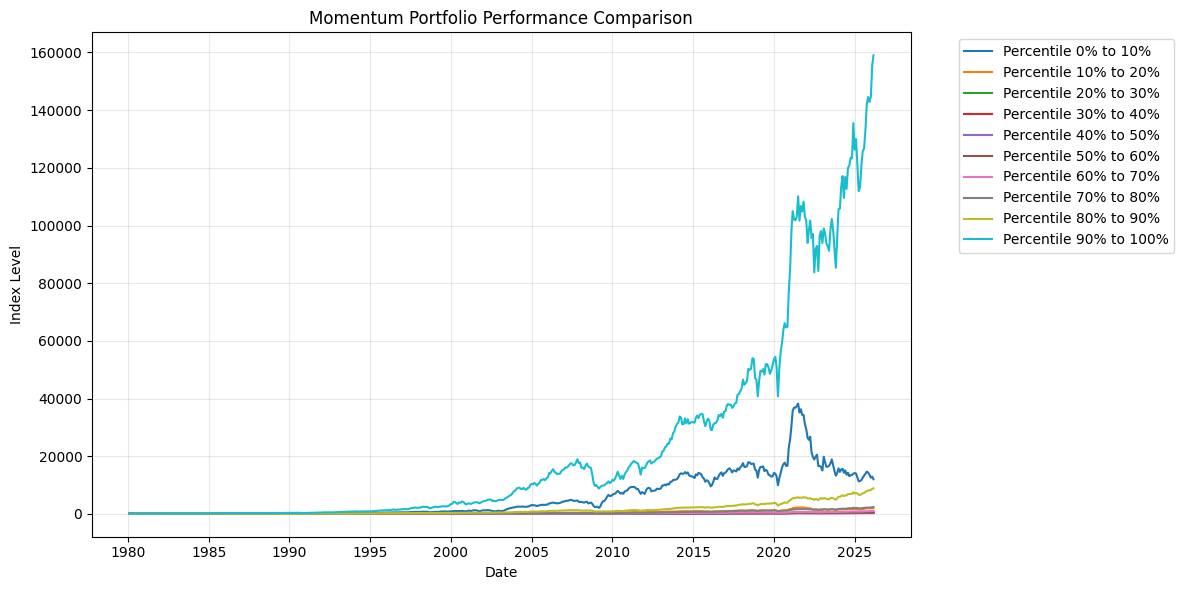

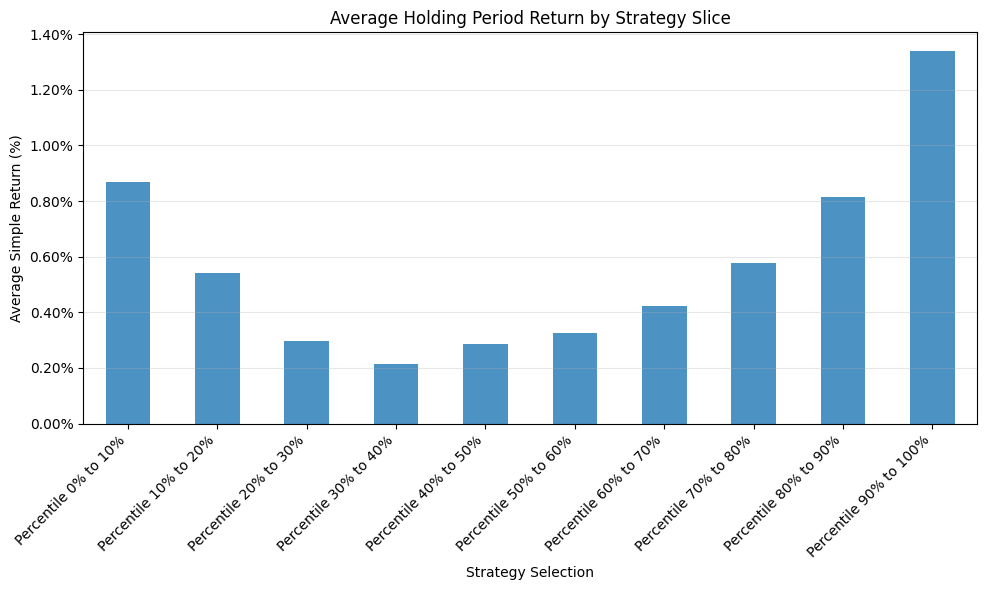

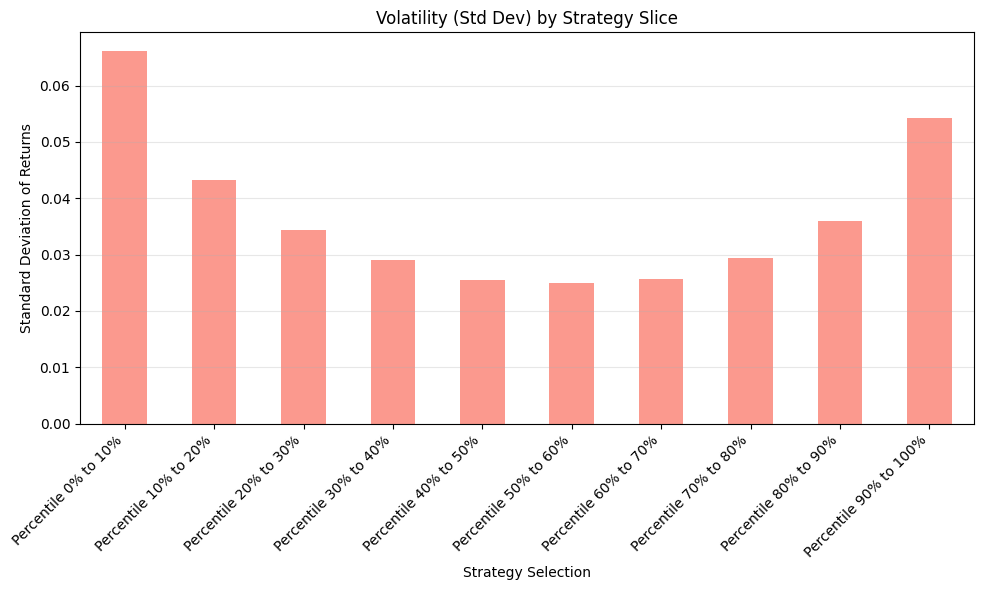


--- Absolute Portfolio Statistics ---
              Strategy Ann. Return Ann. Volatility Sharpe Ratio Max Drawdown
  Percentile 0% to 10%      13.90%          23.47%         0.59      -70.53%
 Percentile 10% to 20%       7.88%          15.04%         0.52      -49.95%
 Percentile 20% to 30%       4.36%          11.84%         0.37      -43.26%
 Percentile 30% to 40%       3.11%           9.99%         0.31      -40.74%
 Percentile 40% to 50%       3.87%           8.77%         0.44      -29.37%
 Percentile 50% to 60%       4.35%           8.58%         0.51      -28.28%
 Percentile 60% to 70%       5.62%           8.83%         0.64      -28.91%
 Percentile 70% to 80%       7.68%          10.15%         0.76      -28.31%
 Percentile 80% to 90%      11.06%          12.38%         0.89      -36.63%
Percentile 90% to 100%      19.37%          18.65%         1.04      -53.52%
---------------------------------------------


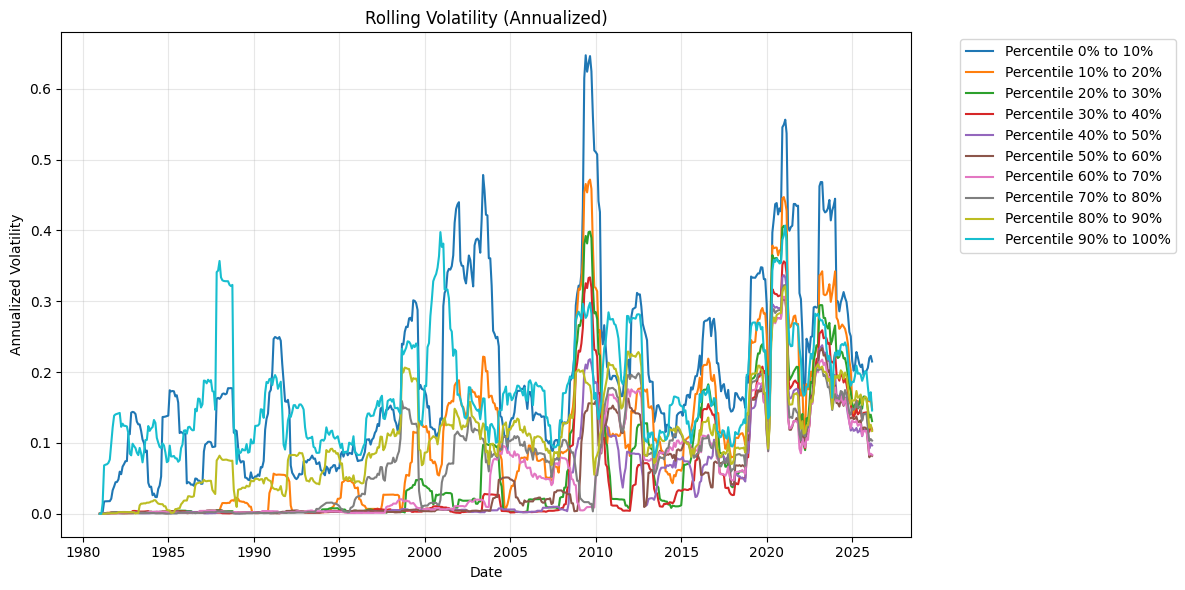

In [9]:
# 1. nittialize the class
Portfolio = MomentumPortfolio()

# 2. Select tickers that are listed from the start date
tickers = select_tickers_listed_from_start_date(START_DATE_LISTED, MIN_AVG_LISTED_PRICE)

# 3. Load the returns data for desired ticekt into memory for the desired time period 
Portfolio.fetch_data(
    tickers=tickers,
    time_start=START_TIME,
    aggregate=AGREGATION_PREIOD_OF_RETURNS,
    clip_extreme_values=CLIP_EXTREME_RETURNS,
)
# 4. Pre compute weights for each eprcentile ranges, using a lookback period, and periods to ignore
Portfolio.construct_performances_for_percentiles(PERCENTILES, LOOKBACK_PERIOD, LAST_PERIODS_TO_IGNORE)


# 4. Plot results
Portfolio.plot_portfolios_over_HPR()
Portfolio.plot_portfolio_average_returns()
Portfolio.plot_portfolio_standard_deviations()
Portfolio.print_portfolio_statistics()

## Since the year 2000

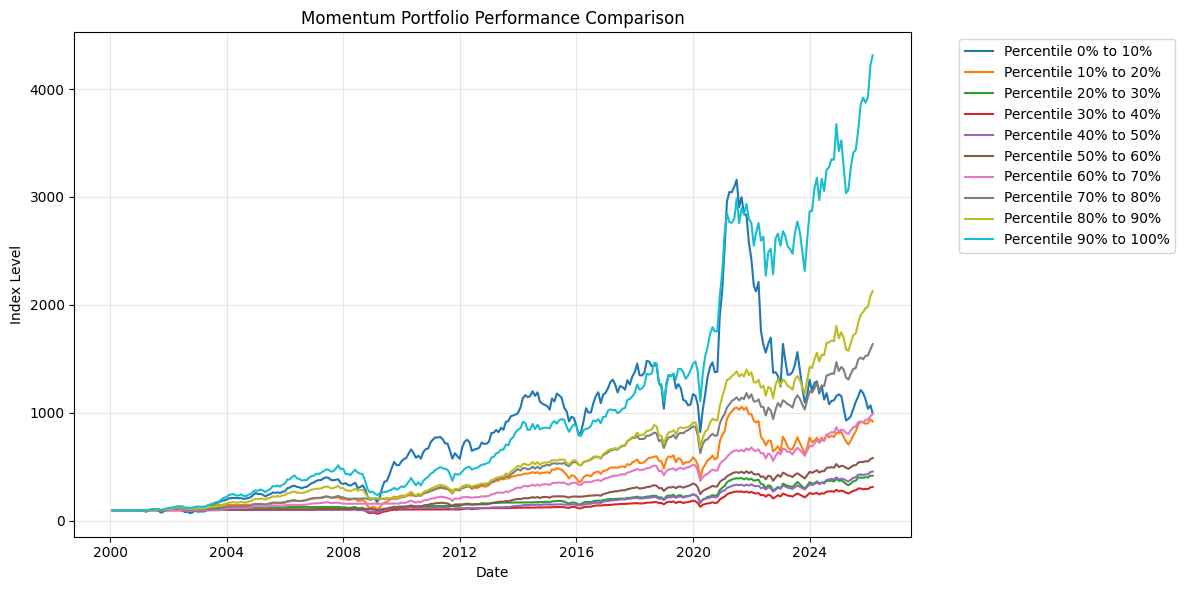

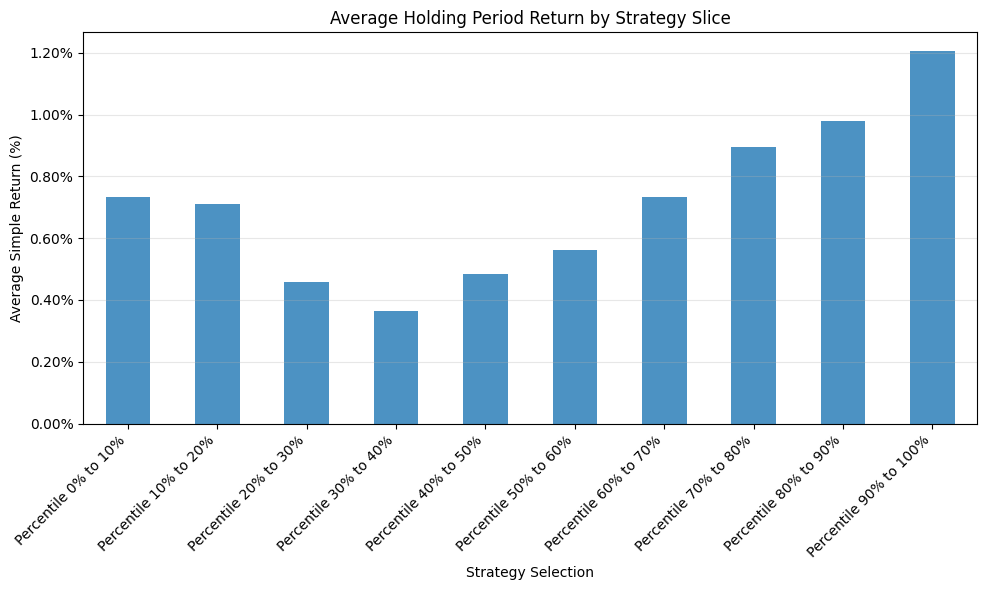

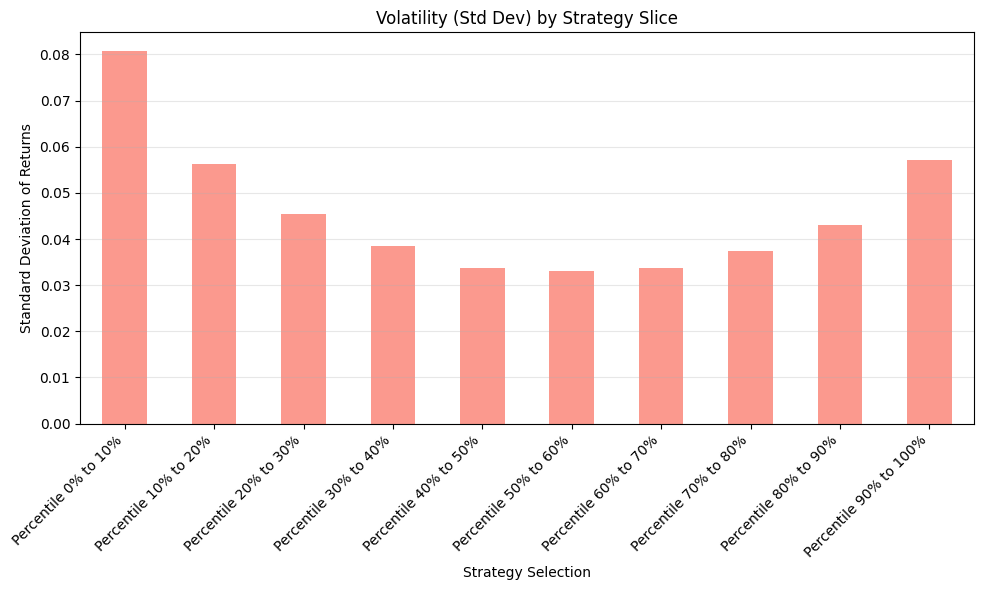


--- Absolute Portfolio Statistics ---
              Strategy Ann. Return Ann. Volatility Sharpe Ratio Max Drawdown
  Percentile 0% to 10%      13.56%          28.70%         0.47      -70.53%
 Percentile 10% to 20%      10.92%          19.54%         0.56      -49.93%
 Percentile 20% to 30%       6.93%          15.66%         0.44      -43.26%
 Percentile 30% to 40%       5.40%          13.24%         0.41      -40.74%
 Percentile 40% to 50%       6.70%          11.59%         0.58      -29.37%
 Percentile 50% to 60%       7.66%          11.32%         0.68      -28.28%
 Percentile 60% to 70%       9.90%          11.60%         0.85      -28.91%
 Percentile 70% to 80%      12.20%          12.85%         0.95      -28.31%
 Percentile 80% to 90%      13.64%          14.88%         0.92      -36.63%
Percentile 90% to 100%      17.72%          19.74%         0.90      -53.52%
---------------------------------------------


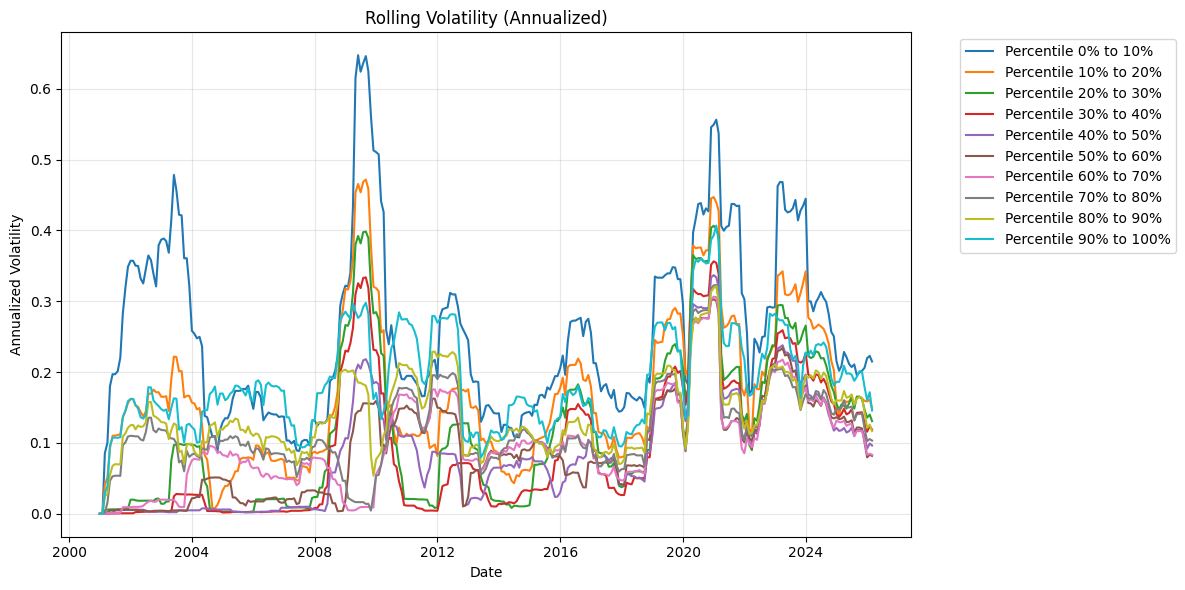

In [10]:
START_TIME = "2000-01-01"
# 1. nittialize the class
Portfolio = MomentumPortfolio()
# 2. Select tickers that are listed from the start date
tickers = select_tickers_listed_from_start_date(START_DATE_LISTED, MIN_AVG_LISTED_PRICE)
# 3. Load the returns data for desired ticekt into memory for the desired time period 
Portfolio.fetch_data(
    tickers=tickers,
    time_start=START_TIME,
    aggregate=AGREGATION_PREIOD_OF_RETURNS,
    clip_extreme_values=CLIP_EXTREME_RETURNS,
)
# 4. Pre compute weights for each eprcentile ranges, using a lookback period, and periods to ignore
Portfolio.construct_performances_for_percentiles(PERCENTILES, LOOKBACK_PERIOD, LAST_PERIODS_TO_IGNORE)
# 5. Plot results
Portfolio.plot_portfolios_over_HPR()
Portfolio.plot_portfolio_average_returns()
Portfolio.plot_portfolio_standard_deviations()
Portfolio.print_portfolio_statistics()

## Since the year 2015

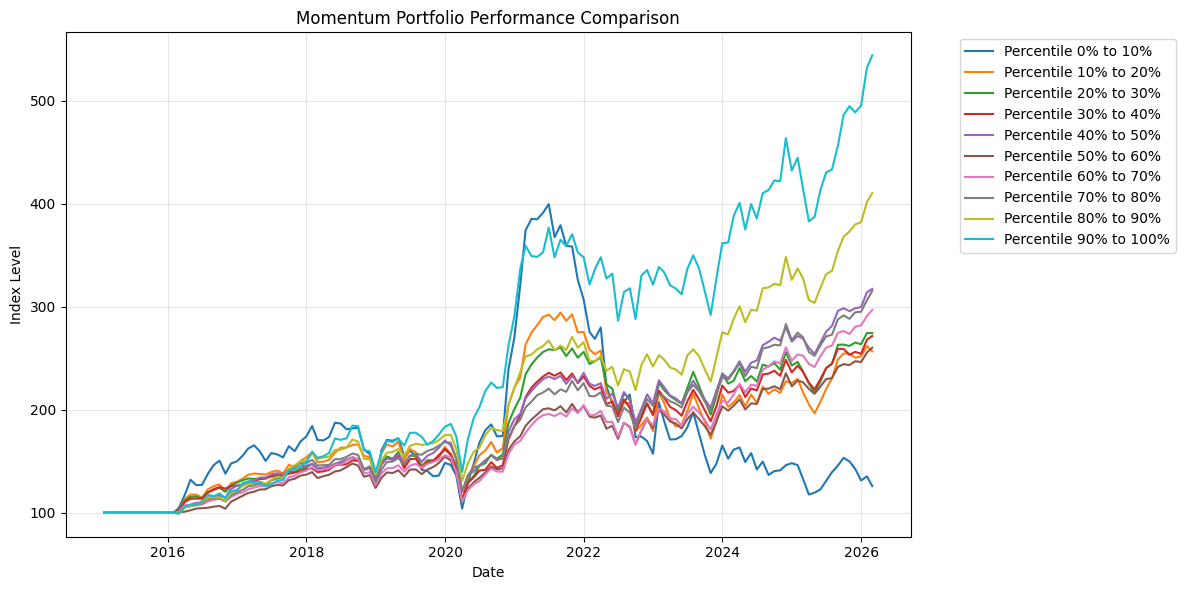

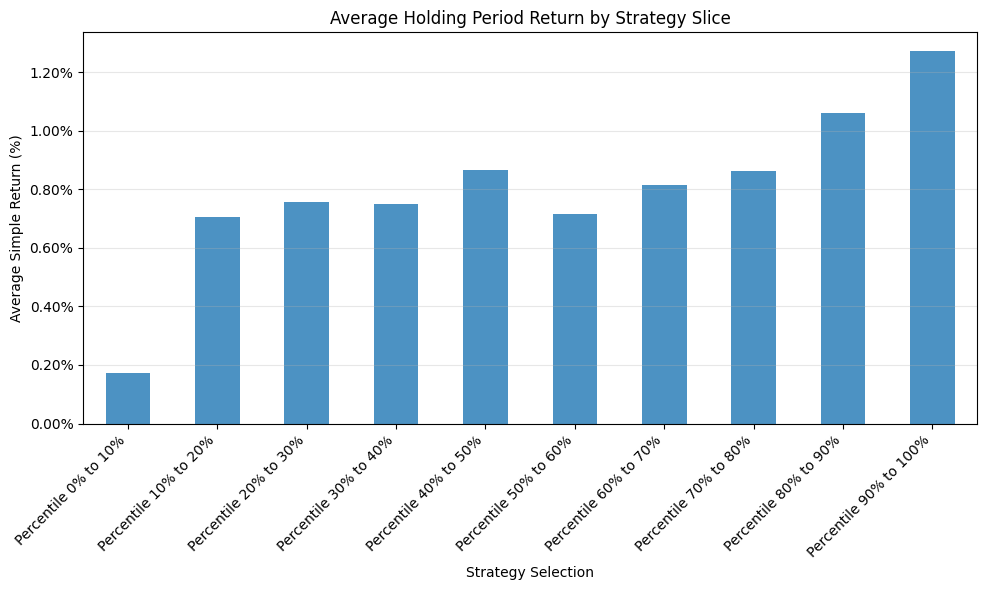

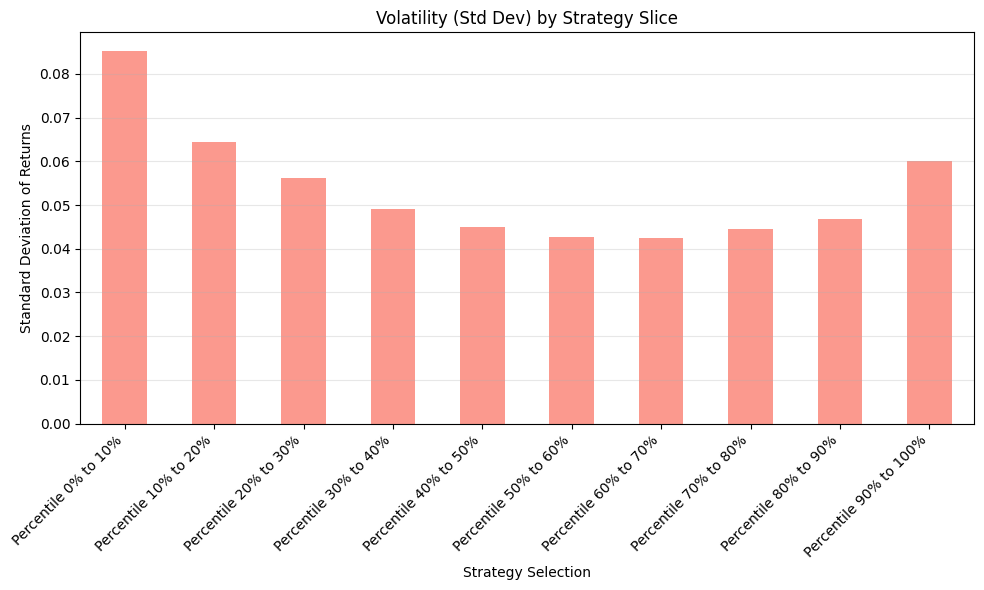


--- Absolute Portfolio Statistics ---
              Strategy Ann. Return Ann. Volatility Sharpe Ratio Max Drawdown
  Percentile 0% to 10%       6.64%          30.21%         0.22      -70.53%
 Percentile 10% to 20%      11.53%          22.54%         0.51      -41.63%
 Percentile 20% to 30%      11.51%          19.34%         0.60      -32.35%
 Percentile 30% to 40%      10.93%          16.93%         0.65      -30.55%
 Percentile 40% to 50%      12.22%          15.40%         0.79      -29.37%
 Percentile 50% to 60%      10.11%          14.57%         0.69      -28.28%
 Percentile 60% to 70%      11.41%          14.44%         0.79      -28.91%
 Percentile 70% to 80%      12.13%          15.23%         0.80      -28.31%
 Percentile 80% to 90%      14.95%          16.13%         0.93      -25.46%
Percentile 90% to 100%      18.89%          21.00%         0.90      -25.07%
---------------------------------------------


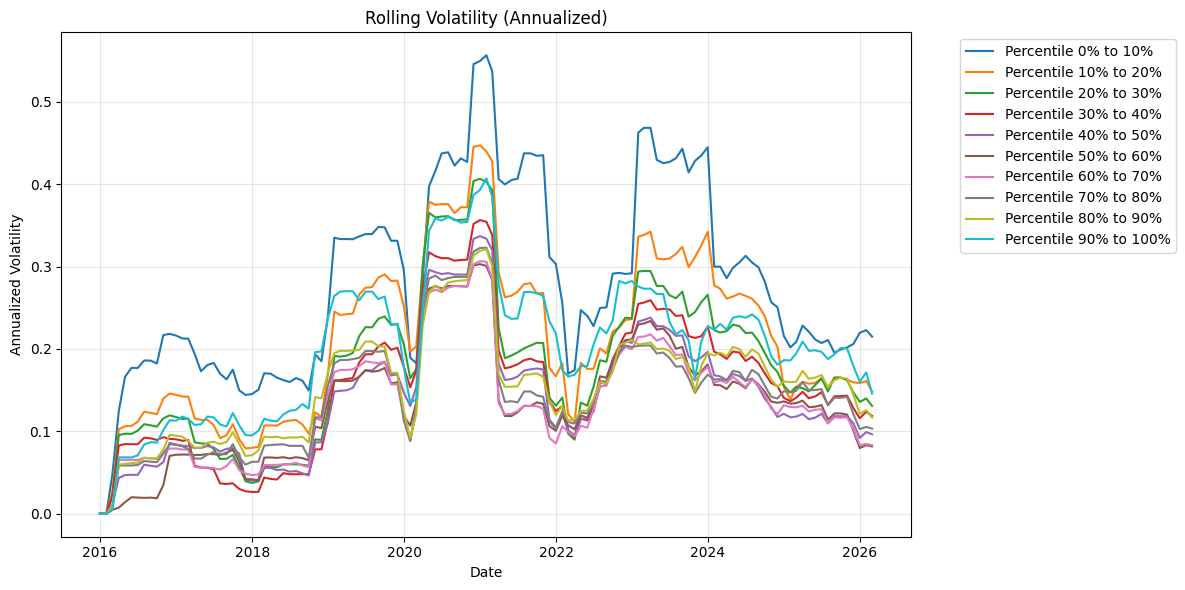

In [11]:
START_TIME = "2015-01-01"
# 1. nittialize the class
Portfolio = MomentumPortfolio()
# 2. Select tickers that are listed from the start date
tickers = select_tickers_listed_from_start_date(START_DATE_LISTED, MIN_AVG_LISTED_PRICE)
# 3. Load the returns data for desired ticekt into memory for the desired time period 
Portfolio.fetch_data(
    tickers=tickers,
    time_start=START_TIME,
    aggregate=AGREGATION_PREIOD_OF_RETURNS,
    clip_extreme_values=CLIP_EXTREME_RETURNS,
)
# 4. Pre compute weights for each eprcentile ranges, using a lookback period, and periods to ignore
Portfolio.construct_performances_for_percentiles(PERCENTILES, LOOKBACK_PERIOD, LAST_PERIODS_TO_IGNORE)
# 5. Plot results
Portfolio.plot_portfolios_over_HPR()
Portfolio.plot_portfolio_average_returns()
Portfolio.plot_portfolio_standard_deviations()
Portfolio.print_portfolio_statistics()

## Very High momentum portfolios

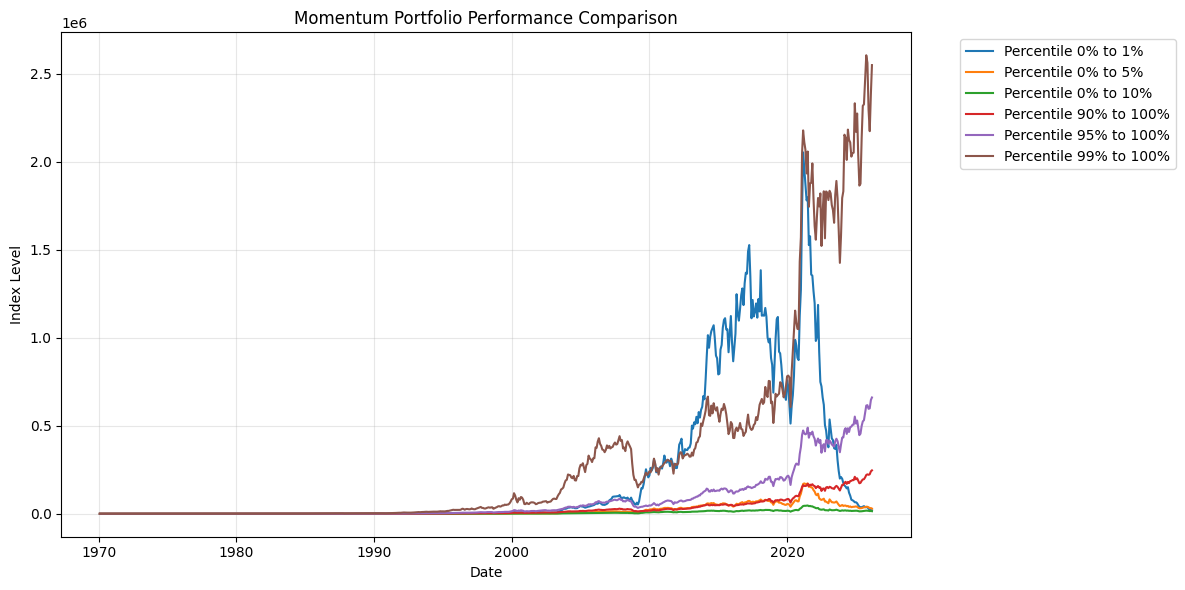

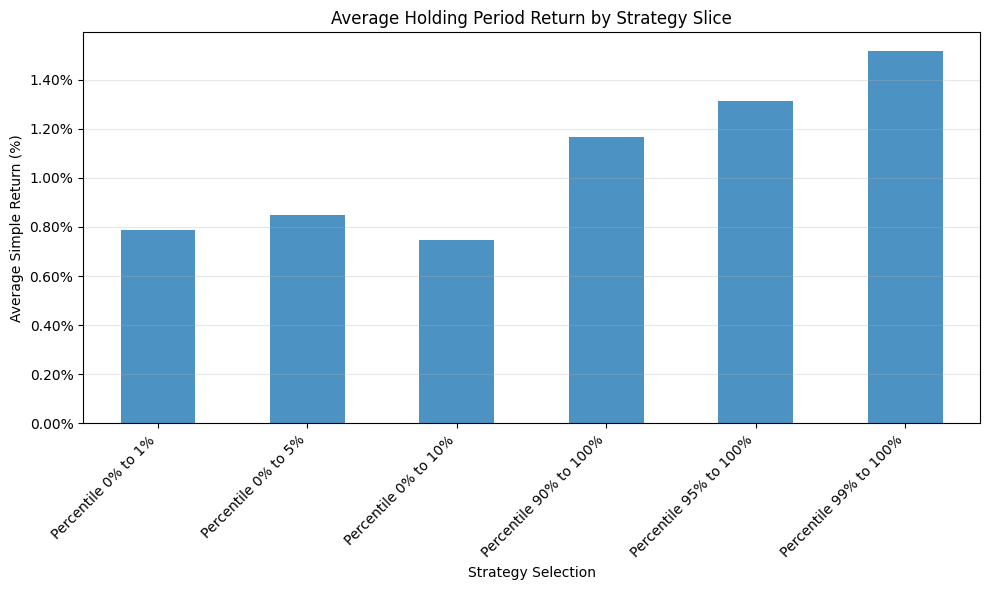

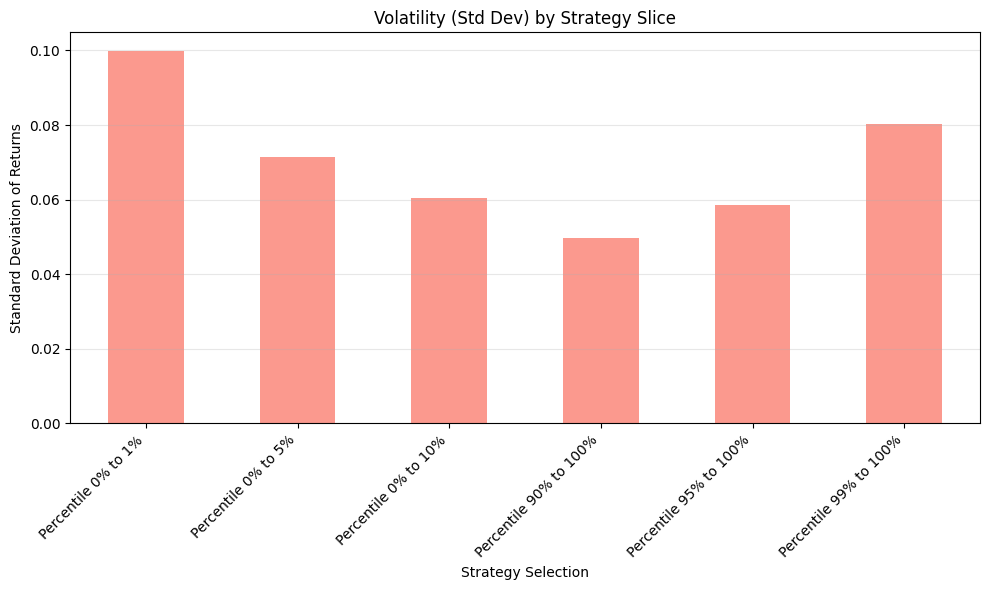


--- Absolute Portfolio Statistics ---
              Strategy Ann. Return Ann. Volatility Sharpe Ratio Max Drawdown
   Percentile 0% to 1%      16.71%          35.87%         0.47      -99.04%
   Percentile 0% to 5%      14.13%          25.50%         0.55      -82.86%
  Percentile 0% to 10%      11.75%          21.43%         0.55      -70.53%
Percentile 90% to 100%      16.61%          17.10%         0.97      -53.52%
Percentile 95% to 100%      19.35%          20.22%         0.96      -61.10%
Percentile 99% to 100%      24.44%          27.87%         0.88      -65.97%
---------------------------------------------


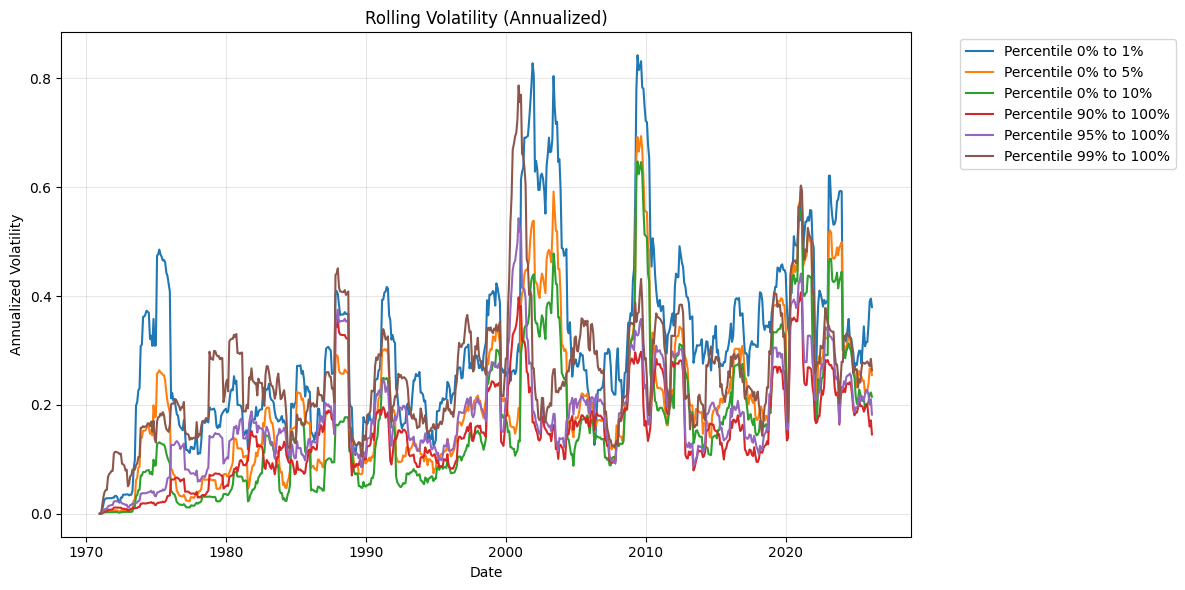

In [12]:
PERCENTILES = [
    (0,1), 
    (0,5), 
    (0,10),  
    (90,100), 
    (95,100), 
    (99,100)
]
START_TIME = "1900-01-01"
# 1. nittialize the class
Portfolio = MomentumPortfolio()
# 2. Select tickers that are listed from the start date
tickers = select_tickers_listed_from_start_date(START_DATE_LISTED, MIN_AVG_LISTED_PRICE)
# 3. Load the returns data for desired ticekt into memory for the desired time period 
Portfolio.fetch_data(
    tickers=tickers,
    time_start=START_TIME,
    aggregate=AGREGATION_PREIOD_OF_RETURNS,
    clip_extreme_values=CLIP_EXTREME_RETURNS,
)
# 4. Pre compute weights for each eprcentile ranges, using a lookback period, and periods to ignore
Portfolio.construct_performances_for_percentiles(PERCENTILES, LOOKBACK_PERIOD, LAST_PERIODS_TO_IGNORE)
# 5. Plot results
Portfolio.plot_portfolios_over_HPR()
Portfolio.plot_portfolio_average_returns()
Portfolio.plot_portfolio_standard_deviations()
Portfolio.print_portfolio_statistics()

In [13]:
# You cna use the Portfolio object to see what is going on in memory betwen steps
#print("Min log return:", np.nanmin(Portfolio.data.values))
#print("Max log return:", np.nanmax(Portfolio.data.values))

In [14]:
#print(Portfolio.percentile_results["Percentile 90% to 100%"])
#Portfolio.data.describe()

In [15]:
# dealocate the previous portfolio to cleanup ram
del Portfolio

# Inherited Long/Short Momentum Portfolio Class Usage

We can Compute Individual Porfolios and use them to do follow up analysis

Requesting SPY... [✓] Success
Saved 8321 rows for SPY
--- Statistics vs Benchmark ---
Beta: -0.2007
Correlation: -0.1703


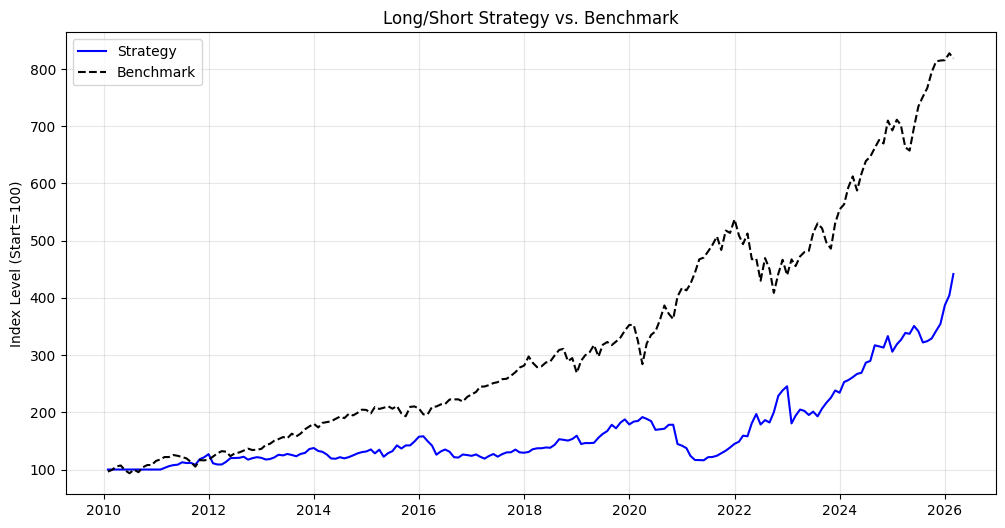

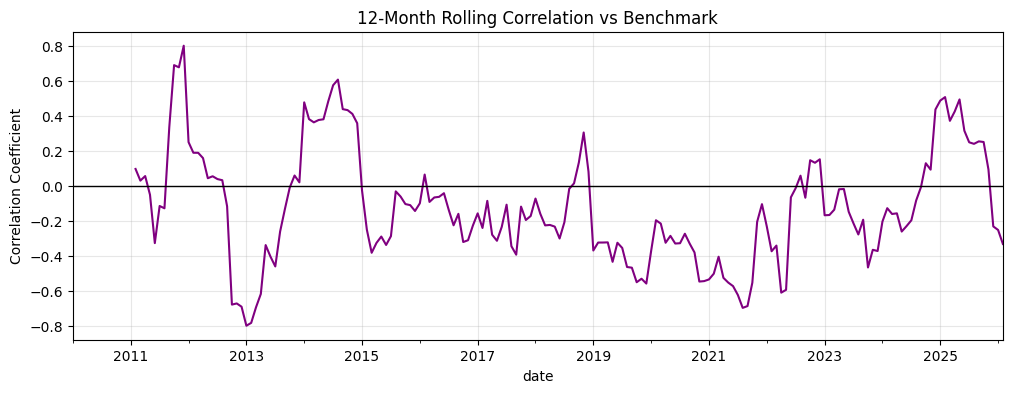

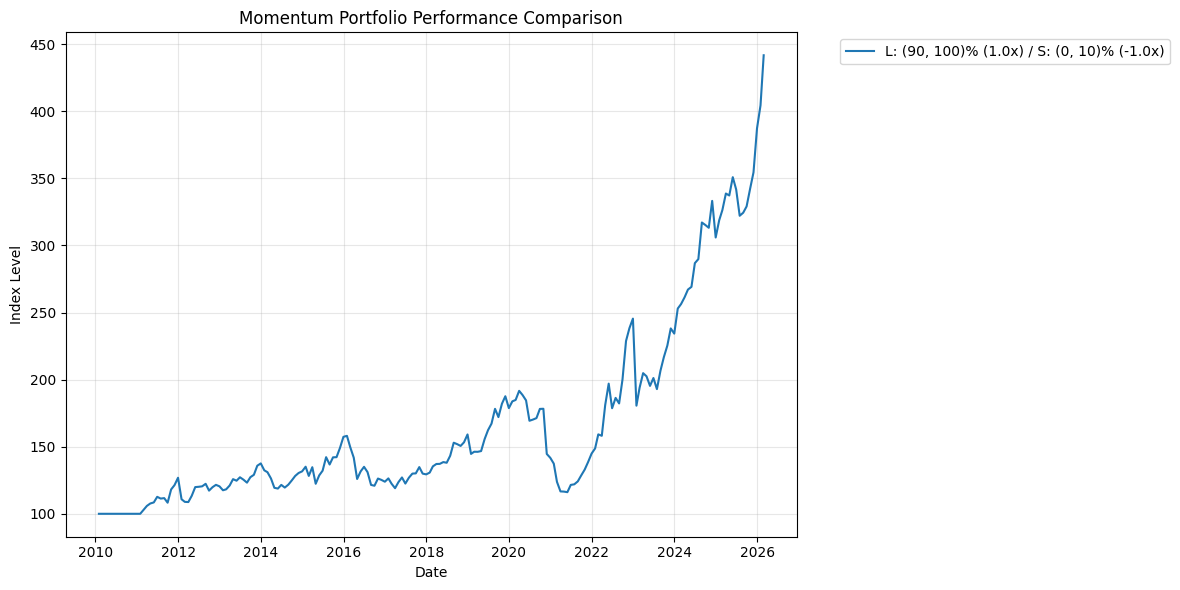

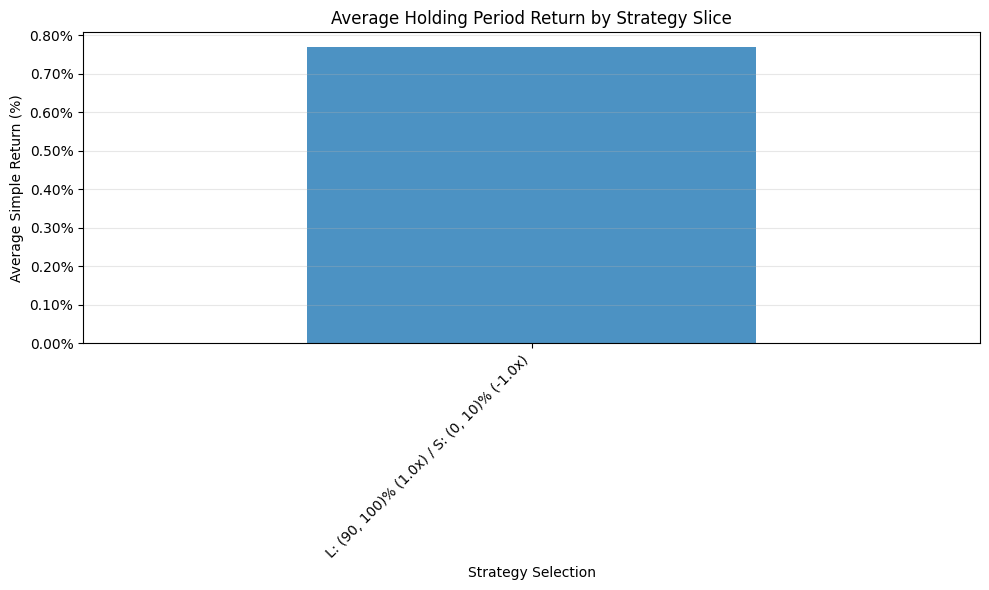

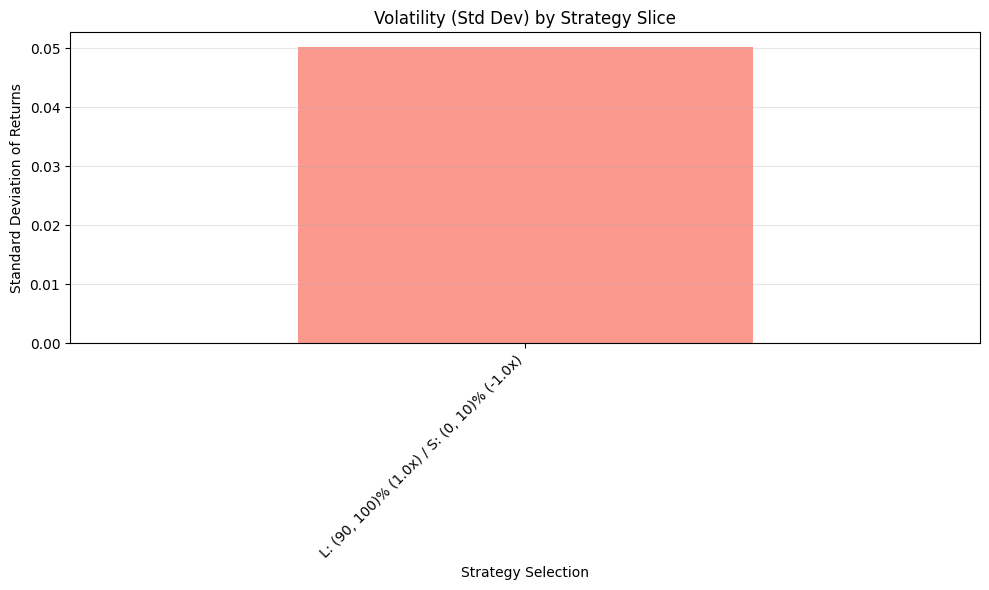


--- Absolute Portfolio Statistics ---
                                  Strategy Ann. Return Ann. Volatility Sharpe Ratio Max Drawdown
L: (90, 100)% (1.0x) / S: (0, 10)% (-1.0x)      11.24%          16.82%         0.67      -39.41%
---------------------------------------------


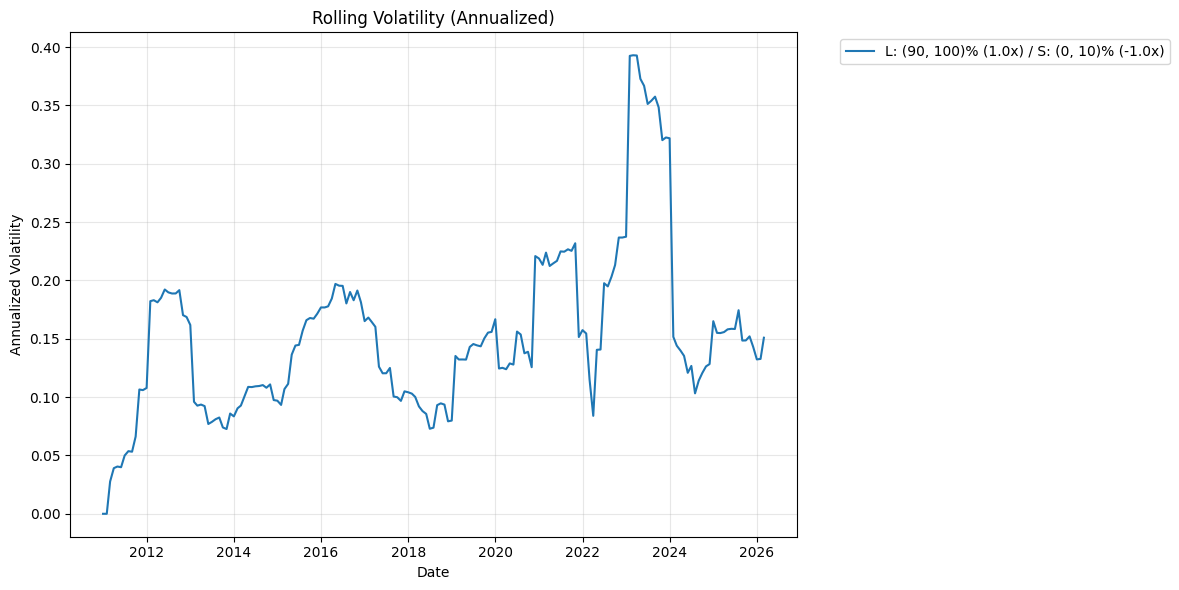


--- Relative Statistics (vs Benchmark) ---
Annualized Alpha:   14.25%
Beta:               -0.20
Information Ratio:  -0.16
Tracking Error:     23.85%
--------------------------------------------------
Strategy Ann. Ret:  11.24%
Benchmark Ann. Ret: 15.04%
--------------------------------------------------


In [16]:
"""
Long Short Portfolio
50% Long top 10% 
50% Short bottom 10%
"""

download_ticker_to_duckdb("SPY")

# Take create an instance of the stock portfolio
long_short_Portfolio = LongShortMomentumPortfolio()
long_short_Portfolio.fetch_data(tickers=tickers, time_start="2010-01-01", aggregate="ME", clip_extreme_values=True)
long_short_Portfolio.fetch_benchmark(ticker='SPY', time_start="2010-01-01", aggregate="ME")

# 3. Construct a Market Neutral Long/Short Portfolio
# E.g., 100% Long Top 10%, 100% Short Bottom 10%
long_short_Portfolio.construct_long_short_portfolio(
    long_percentile=(90, 100), 
    short_percentile=(0, 10),
    long_weight=1.0,
    short_weight=-1.0 # Negative weight creates the short position
)

# 4. Evaluate against the benchmark
long_short_Portfolio.evaluate_against_benchmark()
long_short_Portfolio.plot_portfolios_over_HPR()
long_short_Portfolio.plot_portfolio_average_returns()
long_short_Portfolio.plot_portfolio_standard_deviations()
long_short_Portfolio.print_portfolio_statistics()
long_short_Portfolio.print_relative_statistics()

--- Statistics vs Benchmark ---
Beta: 0.8092
Correlation: 0.7239


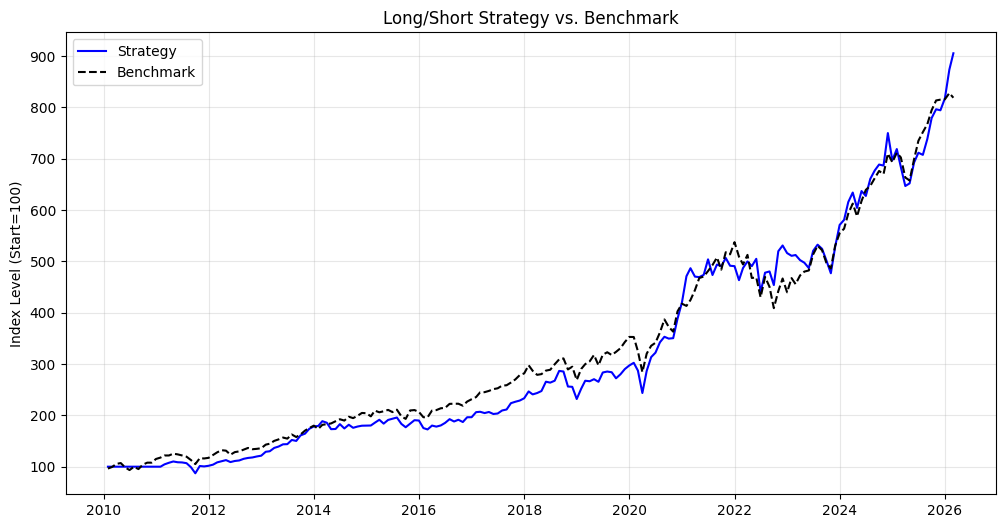

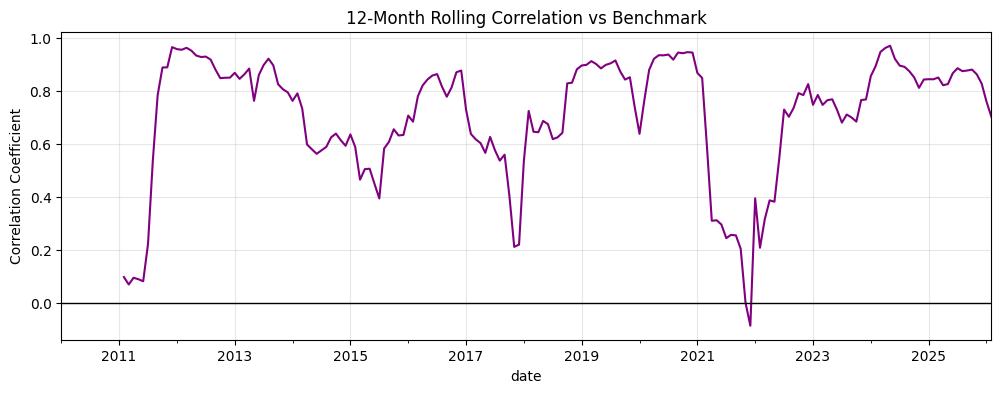

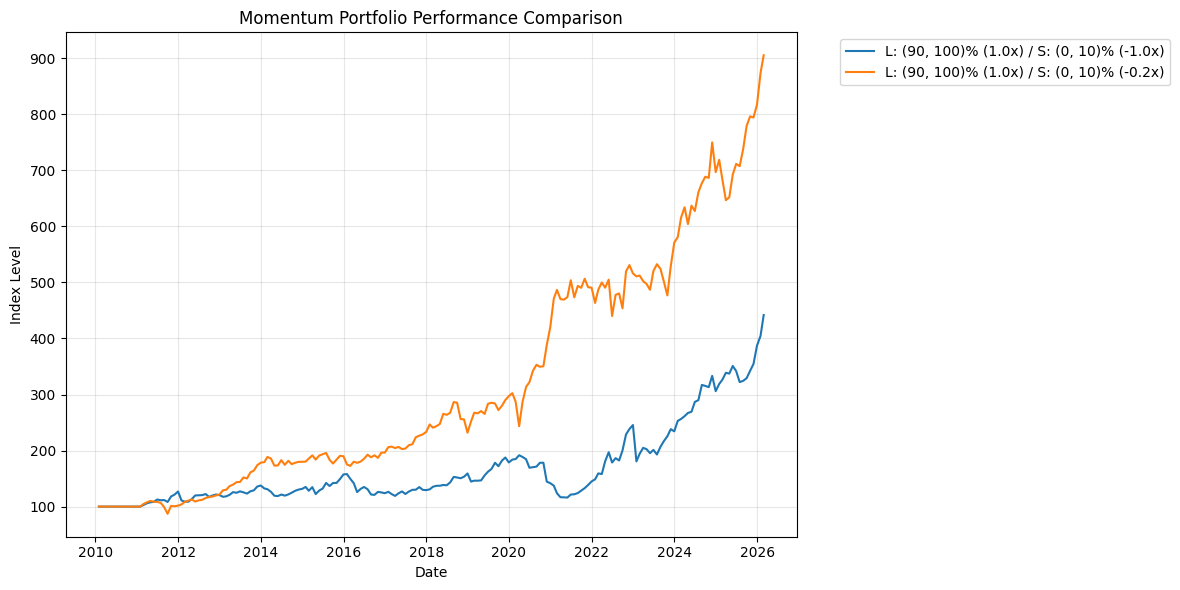

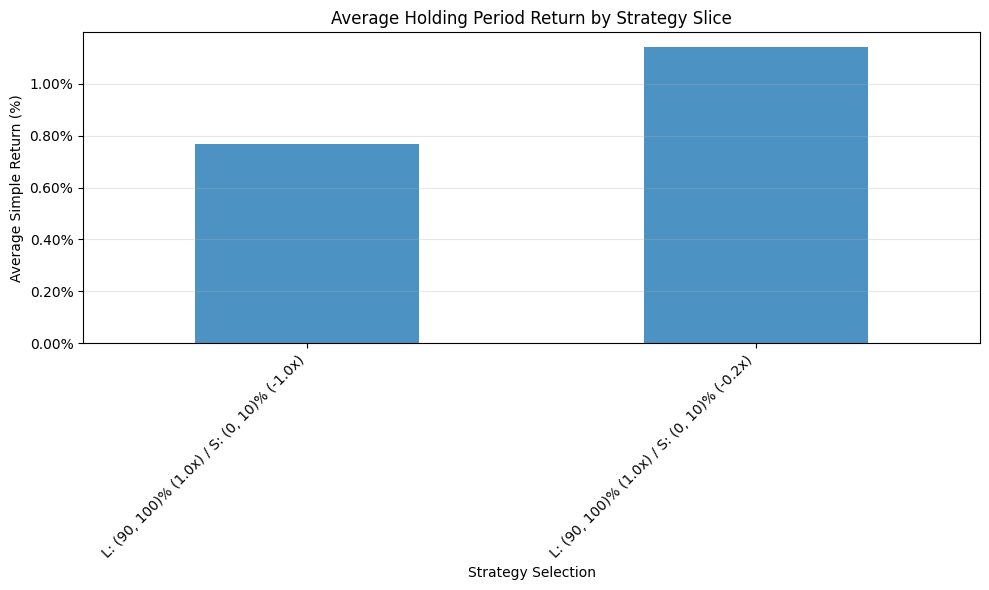

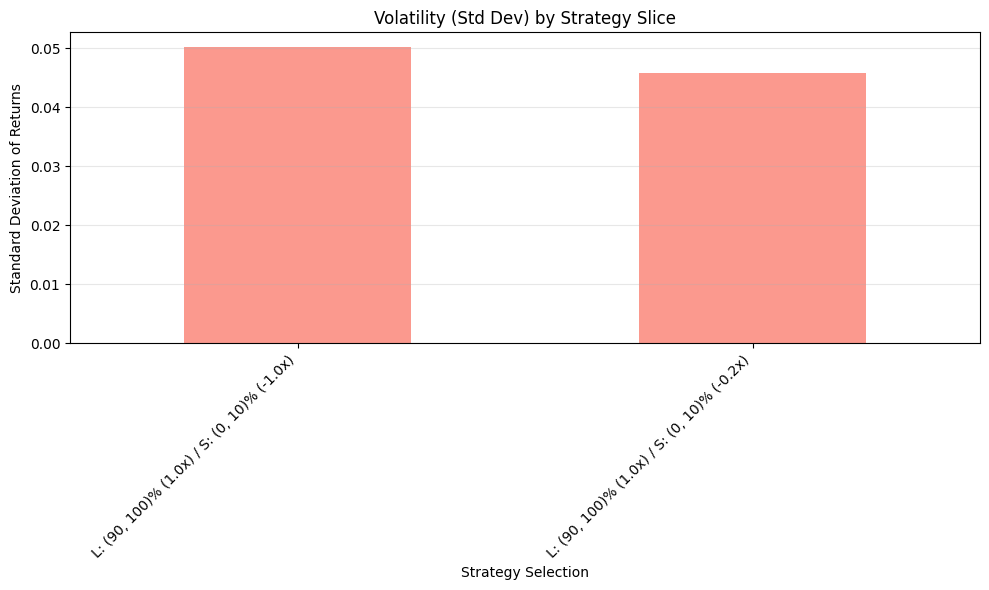


--- Absolute Portfolio Statistics ---
                                  Strategy Ann. Return Ann. Volatility Sharpe Ratio Max Drawdown
L: (90, 100)% (1.0x) / S: (0, 10)% (-1.0x)      11.24%          16.82%         0.67      -39.41%
L: (90, 100)% (1.0x) / S: (0, 10)% (-0.2x)      16.03%          15.96%         1.00      -20.87%
---------------------------------------------


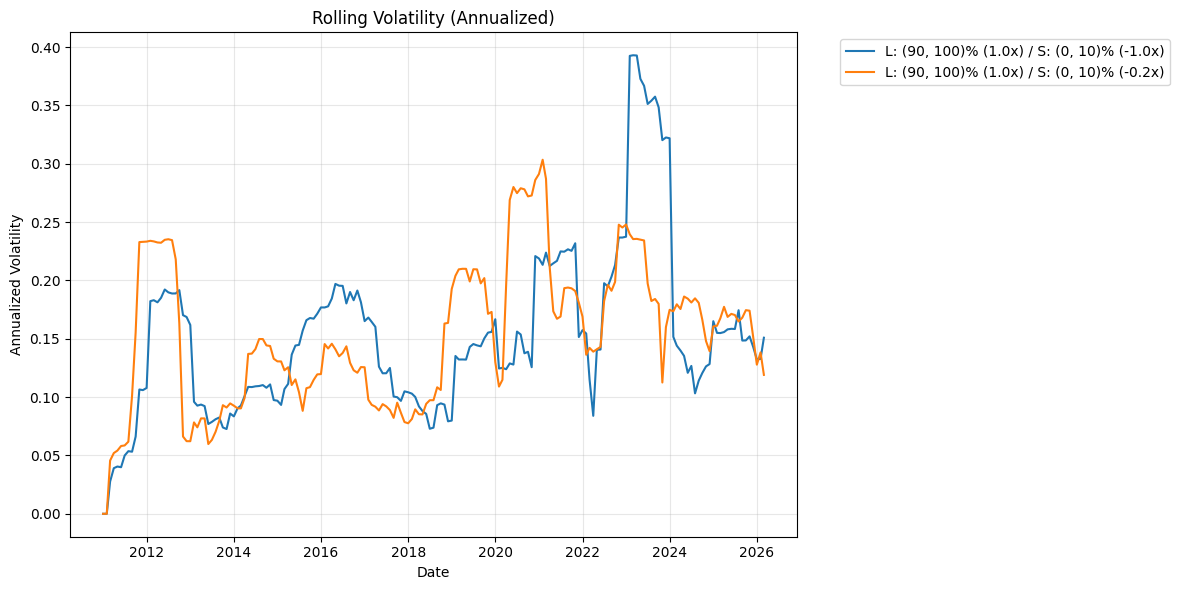


--- Relative Statistics (vs Benchmark) ---
Annualized Alpha:   3.86%
Beta:               0.81
Information Ratio:  0.09
Tracking Error:     11.34%
--------------------------------------------------
Strategy Ann. Ret:  16.03%
Benchmark Ann. Ret: 15.04%
--------------------------------------------------


In [17]:
"""
Long Short Portfolio
80% Long top 10% 
20% Short bottom 10%
"""
long_short_Portfolio.construct_long_short_portfolio(
    long_percentile=(90, 100), 
    short_percentile=(0, 10),
    long_weight=1.0,
    short_weight=-0.2 # Negative weight creates the short position
)
# 2. Evaluate against the benchmark
long_short_Portfolio.evaluate_against_benchmark()
long_short_Portfolio.plot_portfolios_over_HPR()
long_short_Portfolio.plot_portfolio_average_returns()
long_short_Portfolio.plot_portfolio_standard_deviations()
long_short_Portfolio.print_portfolio_statistics()
long_short_Portfolio.print_relative_statistics()

--- Statistics vs Benchmark ---
Beta: 1.0617
Correlation: 0.7600


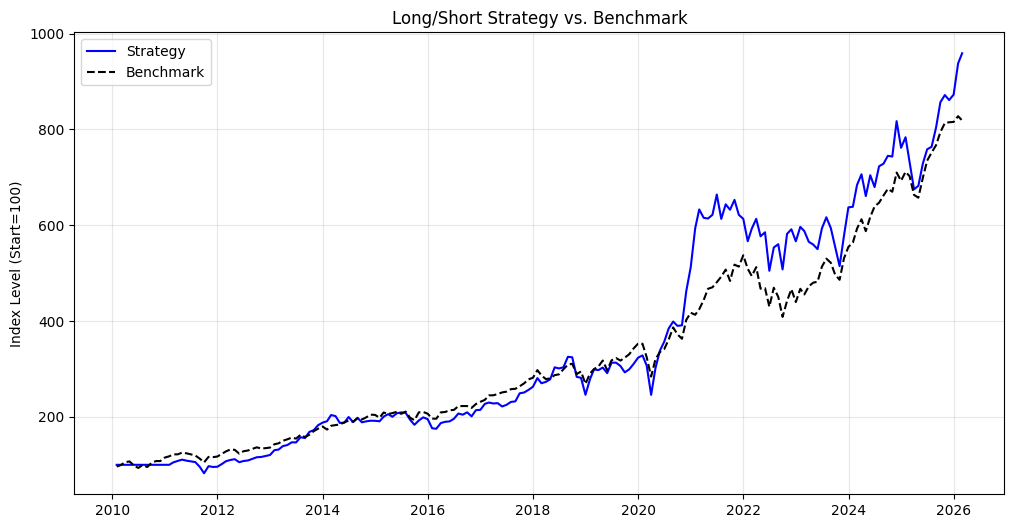

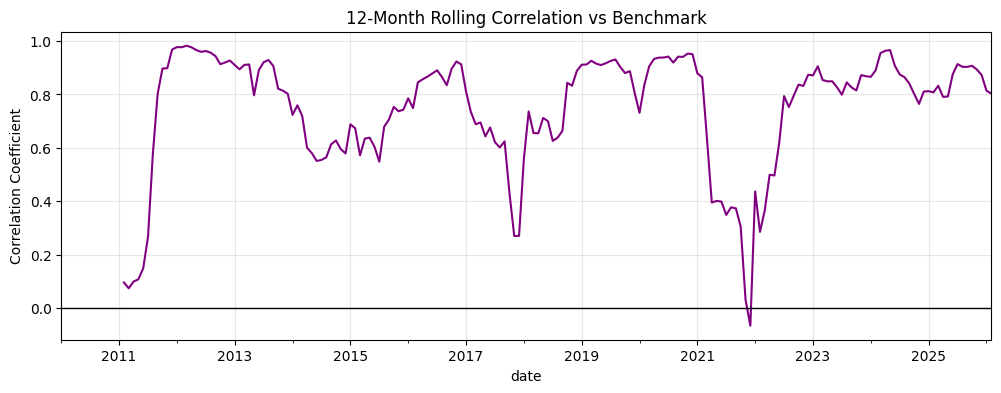

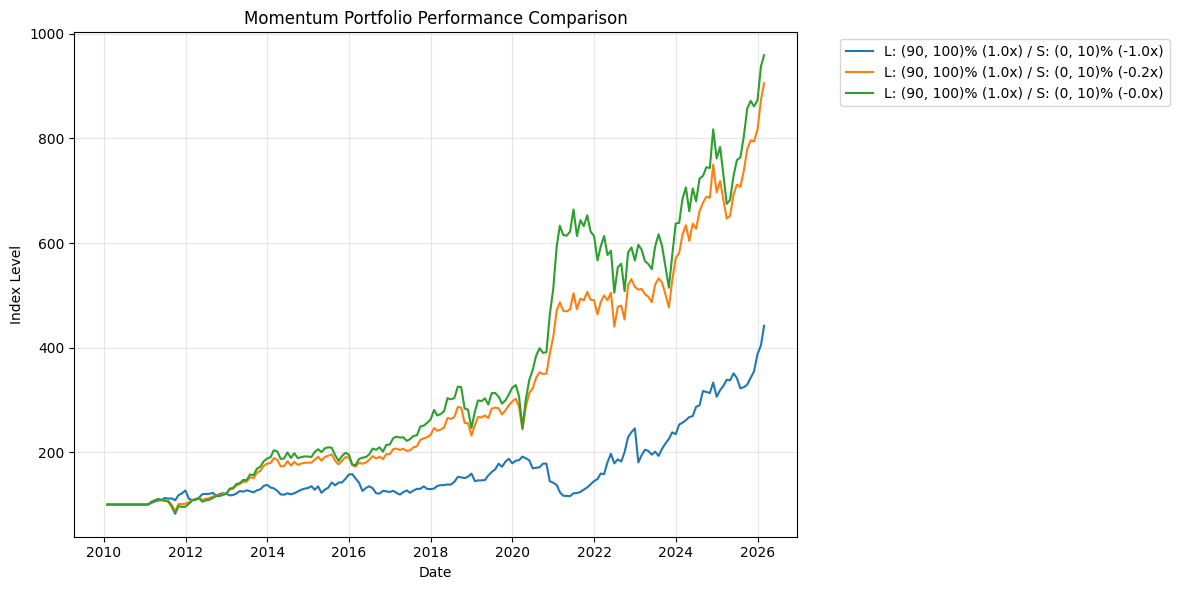

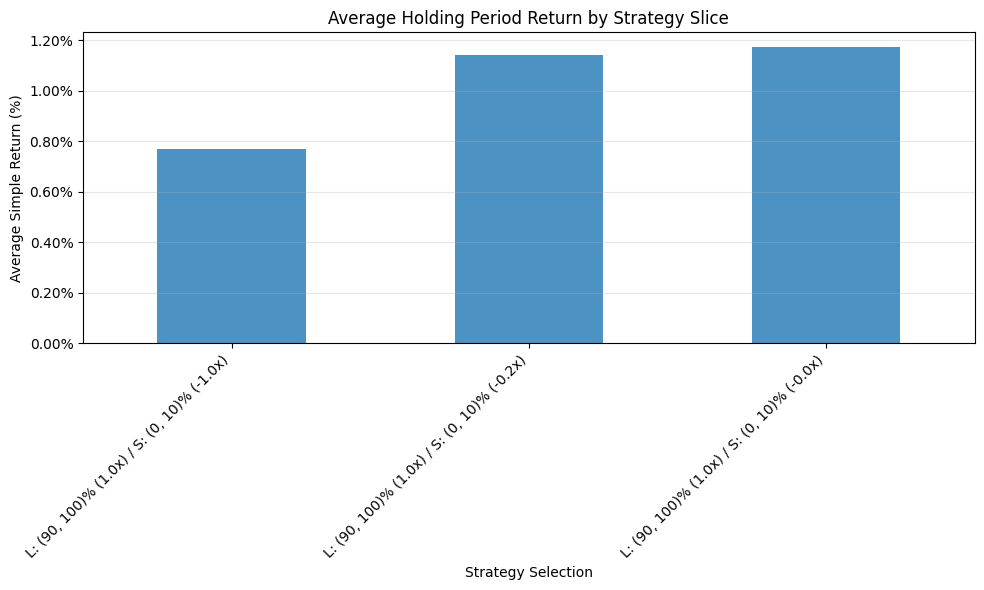

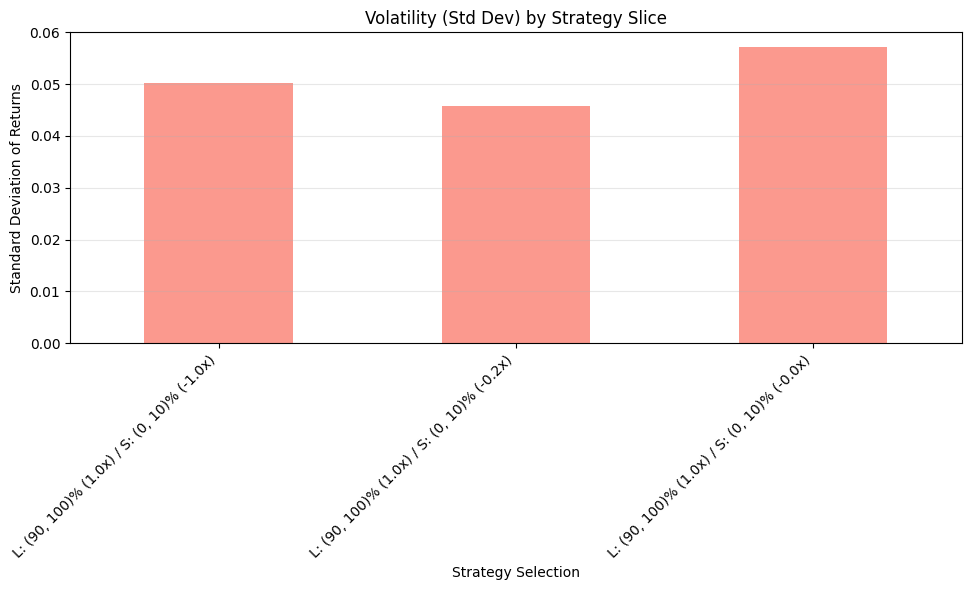


--- Absolute Portfolio Statistics ---
                                  Strategy Ann. Return Ann. Volatility Sharpe Ratio Max Drawdown
L: (90, 100)% (1.0x) / S: (0, 10)% (-1.0x)      11.24%          16.82%         0.67      -39.41%
L: (90, 100)% (1.0x) / S: (0, 10)% (-0.2x)      16.03%          15.96%         1.00      -20.87%
L: (90, 100)% (1.0x) / S: (0, 10)% (-0.0x)      17.26%          19.94%         0.87      -25.68%
---------------------------------------------


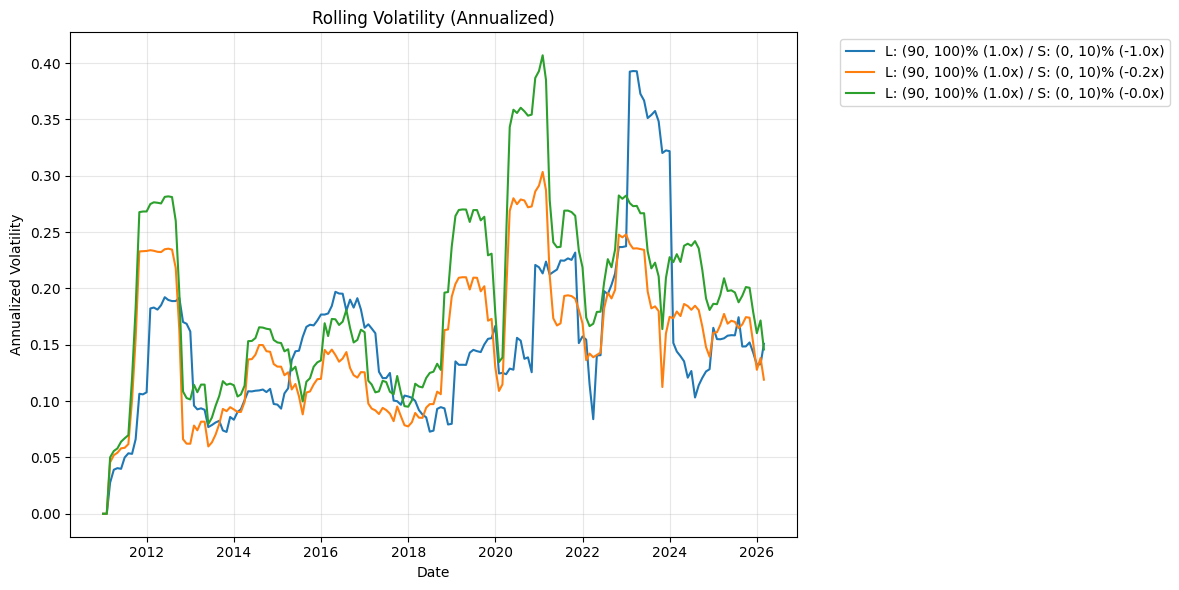


--- Relative Statistics (vs Benchmark) ---
Annualized Alpha:   1.30%
Beta:               1.06
Information Ratio:  0.17
Tracking Error:     12.99%
--------------------------------------------------
Strategy Ann. Ret:  17.26%
Benchmark Ann. Ret: 15.04%
--------------------------------------------------


In [18]:
"""
Long Short Portfolio
100% Long top 10% 
"""
long_short_Portfolio.construct_long_short_portfolio(
    long_percentile=(90, 100), 
    short_percentile=(0, 10),
    long_weight=1.0,
    short_weight=-0.0 # Negative weight creates the short position
)
# 2. Evaluate against the benchmark
long_short_Portfolio.evaluate_against_benchmark()
long_short_Portfolio.plot_portfolios_over_HPR()
long_short_Portfolio.plot_portfolio_average_returns()
long_short_Portfolio.plot_portfolio_standard_deviations()
long_short_Portfolio.print_portfolio_statistics()
long_short_Portfolio.print_relative_statistics()